In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold

import sklearn.metrics as metrics
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
#basedir = '/Users/Nick/Documents/MATLAB/Rao Lab/normalized_data/'
# load data and labels
import file_structure
import copy

def zoompad(array, desired_size):
    array = cv2.resize(array,(desired_size[0],desired_size[1]))
    return array

(origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs('texture')


In [2]:
os.chdir(imagedir)

#patients=next(os.walk('.'))[1]
p_dirs = []
patients = []
for root, dirs, files in os.walk('.'):
    for dn in dirs:
        patients.append(dn)
        p_dirs.append(os.path.join(root,dn))


In [3]:

import sklearn.metrics as metrics
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
def find_correlation(df, thresh=0.8, random_seed= 0):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove as a boolean
    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    corr = df.corr()
    # randomly reorder the columns/rows to only keep one of the columns that has high correlation
    randOrdCorr = corr.sample(frac=1, axis=1,random_state=random_seed).sample(frac=1,random_state=random_seed)
    upper = randOrdCorr.where(np.triu(np.ones(randOrdCorr.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.8
    features_to_remove = [column for column in upper.columns if any(upper[column].abs() > thresh)]
    return features_to_remove
from sklearn.model_selection import KFold

def random_grid():
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
    # Number of features to consider at every split
    max_features = ['sqrt','log2']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    return random_grid

def Logreg_grid():
    # penalty type
    penalty = ['l1','l2']
    # regularization strength
    C = np.logspace(-4,4,9)
    # Create the random grid
    logreg_grid = dict(C=C, penalty = penalty)
    return logreg_grid
def logistic_hyper_parameter_search(train_feat, train_1p19q, val_feat, val_1p19q, C_array):
    result = {'accuracy': [], 'AUC': [], 'sensitivity': [], 'specificity': [], 'C_val': C_array}
    seed = 0

    for C_val in C_array:

        logreg_l1 = LogisticRegression(C=C_val, penalty = 'l1', tol=0.01)
        logreg_l2 = LogisticRegression(C=C_val, penalty = 'l2', tol=0.01)

        logreg_l1.fit(train_feat, train_1p19q)
        logreg_l2.fit(train_feat, train_1p19q)

        Z_l1 = logreg_l1.predict_proba(val_feat)
        Z_l2 = logreg_l2.predict_proba(val_feat)

        # accuracy
        auc_l1 = get_auc(val_1p19q, Z_l1[:,1])[0]
        auc_l2 = get_auc(val_1p19q, Z_l2[:,1])[0]
        # AUC
        acc_l1 = get_accuracy(val_1p19q, np.round(Z_l1[:,1]))
        acc_l2 = get_accuracy(val_1p19q, np.round(Z_l1[:,1]))

        result['AUC'].append([auc_l1, auc_l2])
        result['accuracy'].append([acc_l1, acc_l2])

    # Now, obtain the best C-val with best AUC and Accuracy combo
    AUC_list = result['AUC']
    accuracy_list = result['accuracy']

    summed = np.add(AUC_list, accuracy_list)

    row,col = np.where(summed==summed.max())

    if col[0] == 0:
        best_penalty_type = 'l1'
    else:
        best_penalty_type = 'l2'

    best_c = C_array[row][0]
    #print(AUC_list)
    #print(summed)
    return best_penalty_type, best_c

def get_accuracy(all_gt, all_label):
    return len(np.argwhere(all_gt.reshape([-1,1])==all_label.reshape([-1,1])))/float(len(all_gt))

def Youden_Cutoff_auc_sen_spc(y_true, y_prob):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    y_true : Matrix with dependent or target data, where rows are observations

    y_pred : Matrix with predicted data, where rows are observations

    Returns
    -------     
    auc, youden sensitivity and youden specificity
    """

    fpr, tpr, threshold = roc_curve(y_true, y_prob)

    spc = 1-fpr;
    j_scores = tpr-fpr
    best_youden, youden_thresh, youden_sen, youden_spc = sorted(zip(j_scores, threshold, tpr, spc))[-1]

    predicted_label = copy.deepcopy(y_prob)
    predicted_label[predicted_label>youden_thresh] = 1
    predicted_label[predicted_label<youden_thresh] = 0
    youden_accuracy = get_accuracy(y_true, predicted_label)
    
    idxs = (predicted_label == 1)
    youden_ppv = len(np.argwhere(y_true[idxs]==1))/len(idxs)
    idxs = (predicted_label == 0)
    youden_npv = len(np.argwhere(y_true[idxs]==0))/len(idxs)

    auc = roc_auc_score(y_true, y_prob)

    return auc, youden_sen, youden_spc, youden_accuracy, fpr, tpr, threshold, youden_thresh,youden_ppv,youden_npv

def auc_95confidence(y_true,y_prob,seed = 0):

    # https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

    n_bootstraps = 1000
    bootstrapped_scores = []
    np.random.seed(seed)

    for i in range(n_bootstraps):
        indices = np.random.choice(range(0, len(y_prob)), len(y_prob), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_prob[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    #print(sorted_scores)
    #print(int(0.05 * len(sorted_scores)))
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

def compute_metrics(y_true, y_prob):
    """
    y_true: true label
    y_prob: probability score for class 1
    """
    y_pred = np.round(y_prob)

    #acc = get_accuracy(y_true, y_pred)
    auc, sen, spe, youden_acc, fpr, tpr, threshold, youden_thresh,youden_ppv,youden_npv = Youden_Cutoff_auc_sen_spc(y_true, y_prob)
    lower, upper = auc_95confidence(y_true, y_prob)

    return auc, sen, spe, youden_acc, lower, upper, fpr, tpr, threshold, youden_thresh,youden_ppv,youden_npv

def organize_result(result_dict, case, y_true, y_prob,case_suffix = ''):
    
    if not case in result_dict:
        result_dict[case] = {}
    
    (auc, sen, spe, youden_acc, lower, upper, fpr, tpr, 
     threshold, youden_thresh,youden_ppv,youden_npv) = compute_metrics(y_true, y_prob)
    #cv_score = np.load(os.path.join(model_dir,case_str+'_0'+'_best_cv_score.npy'))
    #pval = auc_p_val(y_true,y_prob)
    val_map = {'Youden Accuracy': youden_acc, 'Sensitivity': sen, 'Specificity': spe,
              'AUC': auc, 'AUC Upper': upper, 'AUC Lower': lower, 'fpr': fpr, 'tpr': tpr,
              'threshold': threshold, 'Youden thresh': youden_thresh,'Youden PPV':youden_ppv,
               'Youden NPV': youden_npv}#, 'CV AUC': cv_score}
    
    for key, val in val_map.items():
        #if key in result_dict[case]:
        #    result_dict[case][key] = np.append(result_dict[case][key],val)
        #else: 
        #    result_dict[case][key] = [val]
        result_dict[case][key] = val
    
    return result_dict

def draw_ROC_curve(result_dict,suffix = '',set_name = 'test set'):

    fig_handle=plt.figure(figsize=(9,8),dpi = 80)
    colors = (['deeppink', 'darkorange','navy','aqua', 'cornflowerblue','lime','orchid',
               'lightcoral','darkcyan','firebrick','forestgreen'])
    lw = 2

    # organize in order of smallest to largest AUC
    res_list = list()
    
    res_keys = list(result_dict.keys())
    for i in range(len(res_keys)):
        case = res_keys[i]
        res_list.append((case,result_dict[case]['AUC'],result_dict[case]['fpr'],result_dict[case]['tpr'],colors[i]))

    ordered_list = sorted(res_list, key = lambda case: case[1])

    #plot
    for ind in range(len(ordered_list)):
        # print(ordered_list[ind][0])

        plt.plot(ordered_list[ind][2], ordered_list[ind][3], color =ordered_list[ind][4], lw= lw,
                label = '{0} ROC curve (area = {1:0.3f})'
                ''.format(ordered_list[ind][0], ordered_list[ind][1]))
        plt.plot(ordered_list[ind][2], ordered_list[ind][3], color = ordered_list[ind][4], lw= lw)

    plt.plot([0,1],[0,1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.tick_params(
        axis='both',
        labelbottom = 'off',
        labelleft = 'off')
    plt.tick_params(axis='both', which= 'major', labelsize = 18)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for %s' % set_name)
    plt.legend(loc="lower right")

    #plt.show()
    plt.savefig(os.path.join(out_dir,'texture_roc'+suffix+'.png'))

    return None


In [4]:

#Load a spreadsheet with patient ID in the first column, age in the third column, and IDH status in the second column
#xl = pd.ExcelFile('/Users/Nick/Documents/MATLAB/Rao Lab/clinical_data_IDH1_1p19q.xlsx')
xl = pd.ExcelFile(os.path.join(basedir,'data','clinical_data_v2.xlsx'))
df = np.asarray(xl.parse("S1A. TCGA discovery dataset"))
#pIdxs =np.arange(np.asarray(df[:,0]).shape[0])[np.in1d(df[:,0],patients)]
pMask = np.in1d(df[:,0],patients)
#print(df)
#print(df[:,0])
#print(patients)
#print(np.intersect1d(df[:,0],patients))
#print(pIdxs)
dfFilt = df[pMask,:] # filter out the rows of the excel file that don't have imaging information

dirIdxs =np.arange(np.asarray(patients).shape[0])[np.in1d(patients,df[:,0])] # filter out the directories 

patients = [patients[i] for i in dirIdxs] # lists have to be handled differently
p_dirs = [p_dirs[i] for i in dirIdxs] 

#print(dfFilt)
patient_age = dfFilt[:,[0,14]]
patient_IDH = dfFilt[:,[0,21]]
patient_1p19q = dfFilt[:,[0,22]]
patient_IDH1_1p19q = dfFilt[:,[0,23]]
patient_OS = dfFilt[:,[0,16]]
patient_gender = dfFilt[:,[0,15]]
patient_KPS = dfFilt[:,[0,18]]
kps_mask = pd.isnull(patient_KPS[:,1])
patient_KPS[kps_mask,1] = 80 # impute KPS when nan to 80
patient_IDH_TF = patient_IDH.copy()
patient_IDH_TF[:,1] = (patient_IDH_TF[:,1] == "Mutant")*1
                                 
print(patient_IDH_TF[:,1])

[1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
demoDict = {'patient': patients, 'age': patient_age[:,1], 'gender': patient_gender[:,1], 'IDH': patient_IDH[:,1], 
            '1p19q':patient_1p19q[:,1], 'IDH_1p19q': patient_IDH1_1p19q[:,1], 'overall_survival': patient_OS[:,1], 
            'KPS': patient_KPS[:,1],'IDH_TF': patient_IDH_TF[:,1]}
# print(demoDict)
patDemo = pd.DataFrame(demoDict,index=patients)
patDemo

,patient,age,gender,IDH,1p19q,IDH_1p19q,overall_survival,KPS,IDH_TF
TCGA-02-0006,TCGA-02-0006,44,female,Mutant,0,IDHmut-non-codel,43.8613,90,1
TCGA-02-0009,TCGA-02-0009,50,male,Mutant,0,IDHmut-non-codel,10.6121,90,1
TCGA-02-0011,TCGA-02-0011,39,male,Mutant,0,IDHmut-non-codel,40.1487,100,1
TCGA-02-0027,TCGA-02-0027,53,female,Mutant,1,IDHmut-codel,9.95503,90,1
TCGA-02-0033,TCGA-02-0033,54,female,WT,0,IDHwt,6.37385,80,0
...,...,...,...,...,...,...,...,...,...
TCGA-HT-8018,TCGA-HT-8018,74,male,WT,0,IDHwt,5.0268,80,0
TCGA-HT-8111,TCGA-HT-8111,54,male,WT,0,IDHwt,0.229984,60,0
TCGA-HT-8114,TCGA-HT-8114,58,male,WT,0,IDHwt,9.26508,80,0
TCGA-HT-8563,TCGA-HT-8563,44,female,WT,0,IDHwt,7.7209,80,0


In [6]:
print(patients[0])

TCGA-02-0006


In [7]:
ftData = pd.read_csv(os.path.join(splitdir,'tumClData.csv'))
# ftData = ftData.drop(labels = ["sliceNo.1"],axis =1)
ftData

,sliceNo,firstorder_10Percentile_FLAIR_tum,firstorder_90Percentile_FLAIR_tum,firstorder_Energy_FLAIR_tum,firstorder_Entropy_FLAIR_tum,firstorder_InterquartileRange_FLAIR_tum,firstorder_Kurtosis_FLAIR_tum,firstorder_Maximum_FLAIR_tum,firstorder_Mean_FLAIR_tum,firstorder_MeanAbsoluteDeviation_FLAIR_tum,...,CNN_504_T2_cl,CNN_505_T2_cl,CNN_506_T2_cl,CNN_507_T2_cl,CNN_508_T2_cl,CNN_509_T2_cl,CNN_510_T2_cl,CNN_511_T2_cl,sliceNo.1,patient
0,0,0.240492,1.295172,21.732593,2.727885,0.786465,2.541692,1.458028,0.761339,0.405381,...,1.494709,0.073630,0.441635,0.094708,0.005920,1.545409,0.210314,0.378143,0,TCGA-02-0006
1,1,-0.096883,1.503480,72.088492,3.239393,0.839631,2.355690,2.045403,0.617030,0.502385,...,1.494709,0.073630,0.441635,0.094708,0.005920,1.545409,0.210314,0.378143,1,TCGA-02-0006
2,2,-0.116473,1.426062,131.527654,3.137464,0.751815,3.655032,2.649052,0.498676,0.479669,...,0.967078,-0.087179,0.869606,0.314239,0.281036,1.338145,0.344545,0.605407,2,TCGA-02-0006
3,3,-0.270368,1.234497,157.250769,3.146925,0.735638,3.069047,2.190985,0.389714,0.469997,...,0.951141,-0.010178,0.920547,0.394832,0.330154,1.301971,0.356470,0.516535,3,TCGA-02-0006
4,4,-0.435929,1.172239,192.573765,3.229288,0.828843,2.801276,1.899814,0.249066,0.493012,...,0.895169,-0.036859,0.879321,0.434050,0.347589,1.299034,0.368861,0.512921,4,TCGA-02-0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6982,73,-1.269009,1.258209,373.902131,3.805428,1.313494,2.594115,2.310902,-0.176086,0.779334,...,1.494709,0.073630,0.441635,0.094708,0.005920,1.545409,0.210314,0.378143,73,TCGA-HT-A61A
6983,74,-1.376298,0.950020,246.541948,3.595241,1.281125,2.507709,1.729381,-0.389593,0.714933,...,1.494709,0.073630,0.441635,0.094708,0.005920,1.545409,0.210314,0.378143,74,TCGA-HT-A61A
6984,75,-1.428383,0.393548,143.775775,3.301772,0.959813,2.311642,0.854481,-0.642006,0.556893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,TCGA-HT-A61A
6985,76,-1.436852,-0.284341,87.136083,2.748171,0.651928,2.184490,-0.004986,-0.900406,0.366425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,TCGA-HT-A61A


In [8]:
combDF = pd.merge(ftData,patDemo,left_on='patient',right_on='patient')
combDF.to_csv(os.path.join(splitdir,'tumClPatData.csv'))
combDF

,sliceNo,firstorder_10Percentile_FLAIR_tum,firstorder_90Percentile_FLAIR_tum,firstorder_Energy_FLAIR_tum,firstorder_Entropy_FLAIR_tum,firstorder_InterquartileRange_FLAIR_tum,firstorder_Kurtosis_FLAIR_tum,firstorder_Maximum_FLAIR_tum,firstorder_Mean_FLAIR_tum,firstorder_MeanAbsoluteDeviation_FLAIR_tum,...,sliceNo.1,patient,age,gender,IDH,1p19q,IDH_1p19q,overall_survival,KPS,IDH_TF
0,0,0.240492,1.295172,21.732593,2.727885,0.786465,2.541692,1.458028,0.761339,0.405381,...,0,TCGA-02-0006,44,female,Mutant,0,IDHmut-non-codel,43.8613,90,1
1,1,-0.096883,1.503480,72.088492,3.239393,0.839631,2.355690,2.045403,0.617030,0.502385,...,1,TCGA-02-0006,44,female,Mutant,0,IDHmut-non-codel,43.8613,90,1
2,2,-0.116473,1.426062,131.527654,3.137464,0.751815,3.655032,2.649052,0.498676,0.479669,...,2,TCGA-02-0006,44,female,Mutant,0,IDHmut-non-codel,43.8613,90,1
3,3,-0.270368,1.234497,157.250769,3.146925,0.735638,3.069047,2.190985,0.389714,0.469997,...,3,TCGA-02-0006,44,female,Mutant,0,IDHmut-non-codel,43.8613,90,1
4,4,-0.435929,1.172239,192.573765,3.229288,0.828843,2.801276,1.899814,0.249066,0.493012,...,4,TCGA-02-0006,44,female,Mutant,0,IDHmut-non-codel,43.8613,90,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6982,73,-1.269009,1.258209,373.902131,3.805428,1.313494,2.594115,2.310902,-0.176086,0.779334,...,73,TCGA-HT-A61A,49,female,WT,0,IDHwt,7.78661,80,0
6983,74,-1.376298,0.950020,246.541948,3.595241,1.281125,2.507709,1.729381,-0.389593,0.714933,...,74,TCGA-HT-A61A,49,female,WT,0,IDHwt,7.78661,80,0
6984,75,-1.428383,0.393548,143.775775,3.301772,0.959813,2.311642,0.854481,-0.642006,0.556893,...,75,TCGA-HT-A61A,49,female,WT,0,IDHwt,7.78661,80,0
6985,76,-1.436852,-0.284341,87.136083,2.748171,0.651928,2.184490,-0.004986,-0.900406,0.366425,...,76,TCGA-HT-A61A,49,female,WT,0,IDHwt,7.78661,80,0


In [9]:

extra_cols = ['Unnamed: 0','sliceNo.1']
id_cols = ['sliceNo','patient']
feat_only_cols = list((set(ftData.columns) - set(extra_cols)) - set(id_cols))

print(set([ft[-3:] for ft in feat_only_cols]))
# print(featOnlyCols)
orig_names = list(set(['_'.join(ft.split('_')[:-1]) for ft in feat_only_cols]))

# print(orig_names)
featDict = {}
featDict['tum'] = {}
featDict['cl'] = {}
for ft in feat_only_cols:
    spl_str = ft.split('_')
    ft_type = spl_str[-1]
    orig_ft = '_'.join(ft.split('_')[:-1])
    featDict[ft_type][orig_ft] = ft
print(featDict)


{'tum', '_cl'}
{'tum': {'CNN_375_FLAIR': 'CNN_375_FLAIR_tum', 'glrlm_RunLengthNonUniformity_T1post': 'glrlm_RunLengthNonUniformity_T1post_tum', 'CNN_508_FLAIR': 'CNN_508_FLAIR_tum', 'std(death)_0_T1post': 'std(death)_0_T1post_tum', 'CNN_350_T1post': 'CNN_350_T1post_tum', 'CNN_401_FLAIR': 'CNN_401_FLAIR_tum', 'CNN_366_T1post': 'CNN_366_T1post_tum', 'CNN_262_T1post': 'CNN_262_T1post_tum', 'mean(death_max-death)_0_T1post': 'mean(death_max-death)_0_T1post_tum', 'CNN_330_T1post': 'CNN_330_T1post_tum', 'CNN_180_FLAIR': 'CNN_180_FLAIR_tum', 'CNN_009_T1': 'CNN_009_T1_tum', 'CNN_489_T1': 'CNN_489_T1_tum', 'mean(bar length)_0_T1': 'mean(bar length)_0_T1_tum', 'CNN_231_T2': 'CNN_231_T2_tum', 'CNN_365_T2': 'CNN_365_T2_tum', 'median(birth)_0_T1': 'median(birth)_0_T1_tum', 'CNN_251_T1': 'CNN_251_T1_tum', 'CNN_398_T1post': 'CNN_398_T1post_tum', 'CNN_179_FLAIR': 'CNN_179_FLAIR_tum', 'CNN_010_T1': 'CNN_010_T1_tum', 'glrlm_HighGrayLevelRunEmphasis_T2': 'glrlm_HighGrayLevelRunEmphasis_T2_tum', 'CNN_281_T

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

res_arr = []
result = {}
r_seeds = range(40)
random_seed = 1
# lr_f_imps = pd.DataFrame(data=np.zeros((len(r_seeds),len(rfData.columns))), columns=rfData.columns)
# rf_f_imps = pd.DataFrame(data=np.zeros((len(r_seeds),len(rfData.columns))), columns=rfData.columns)
# for random_seed in r_seeds:

sss = StratifiedShuffleSplit(n_splits =1, test_size = 0.2, random_state = random_seed)
label_id = combDF[['patient']]
label_id_comb = np.hstack((label_id.values,np.arange(combDF.shape[0]).reshape(-1,1)))
u_label_id_comb = label_id.drop_duplicates().values
# print(label_id_comb,u_label_id_comb)
[train_test_split] = sss.split(u_label_id_comb[:,0],np.ones(u_label_id_comb[:,0].shape))
tt0 = train_test_split[0]
tt1 = train_test_split[1]
tMask = (combDF['patient'].isin(u_label_id_comb[tt0,0]))

data_train = combDF.loc[(tMask)].copy()

data_train = data_train.dropna(axis = 0) # filter nans
print(tt0,tt1)

[ 74  46  80  95  99  86  85  88  44  31  61  90  89  32  55  81 102   4
  96  13  52  48  67  92  83  26  27  35  62  19  94  69 108  22   3  38
  30  43  39  97 106  15 103  51  42  45  36  17  33  60  21  47  10  34
  23 105 109  77  78  91   0  66  93 101  53  68  82  70  98  63  56  57
 100  24   2  59  73   8  87  14  54  65 104   7  41  49  40  58] [107  25  50   1  20  79  16  28   5   9  75  71  11  37  18  12  29  84
  64   6  76  72]


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\envs\tcia\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


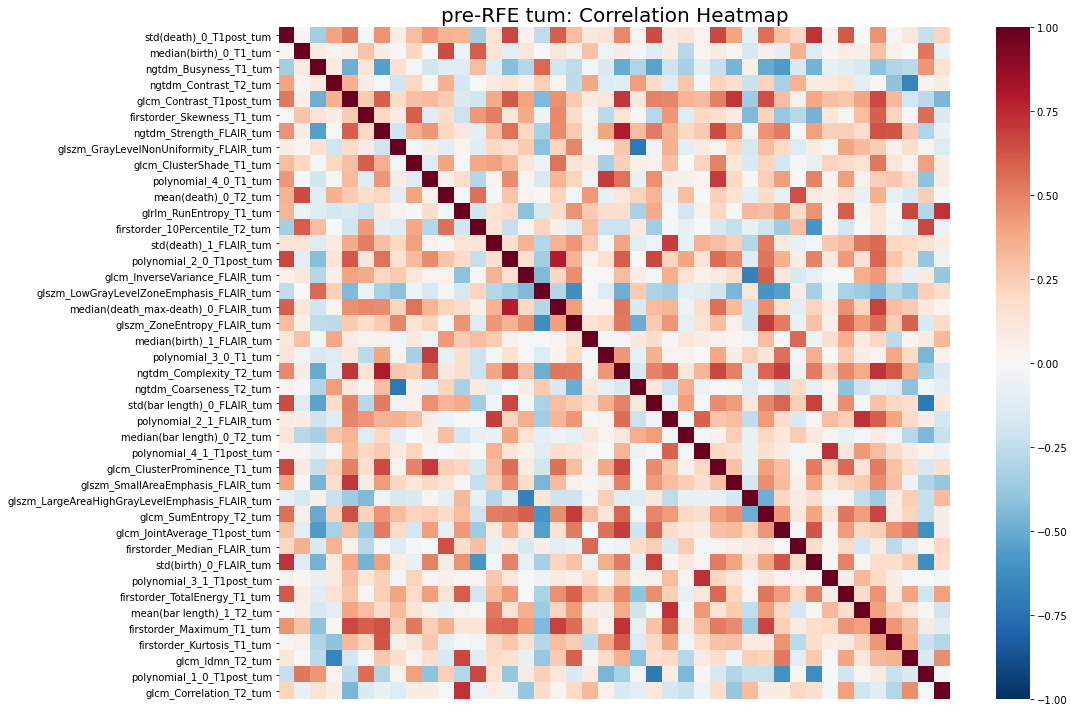

No handles with labels found to put in legend.


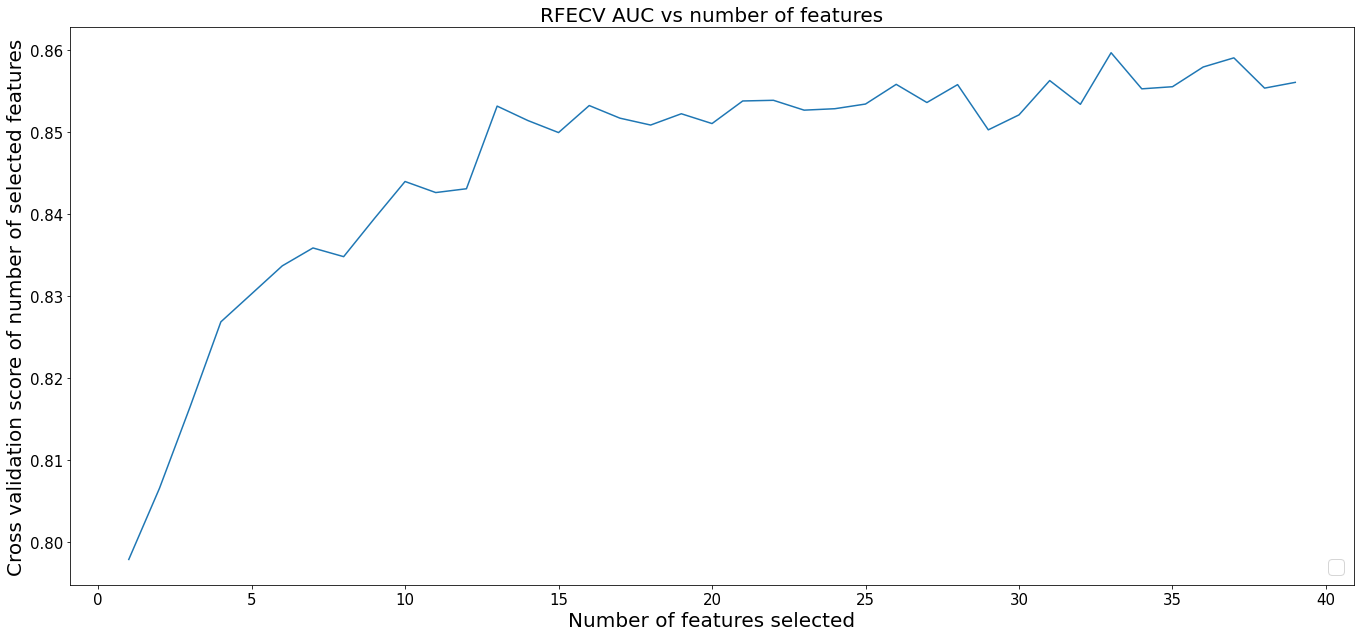

36 42 0.8571428571428571


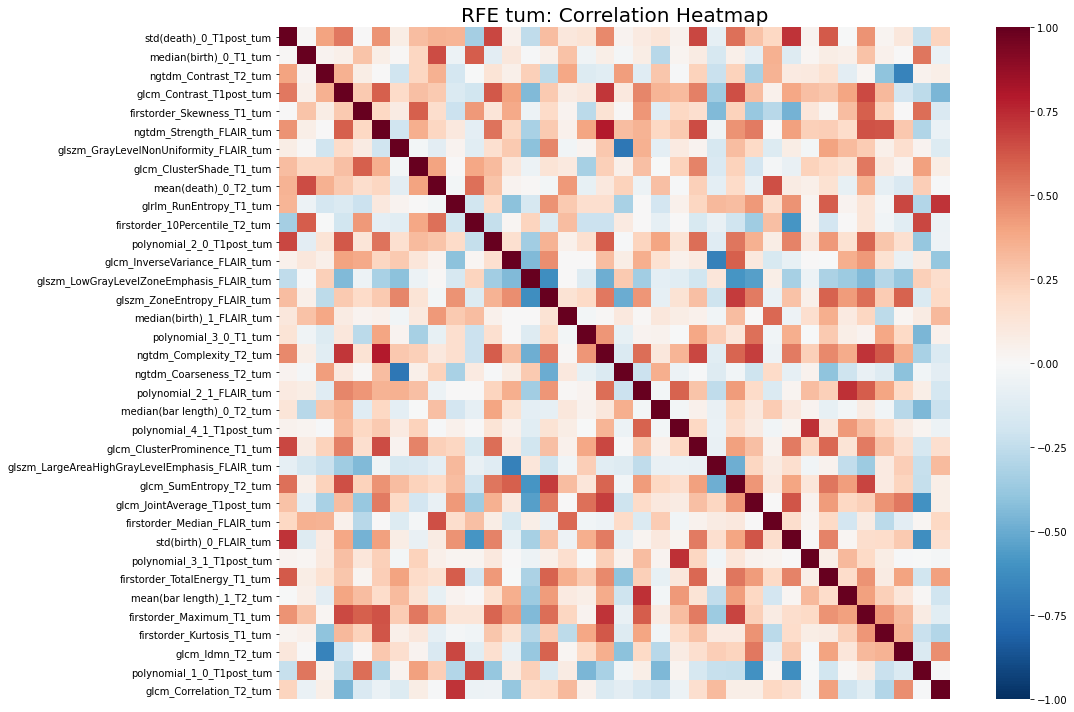

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished


rf_auc: 0.9911775677137337


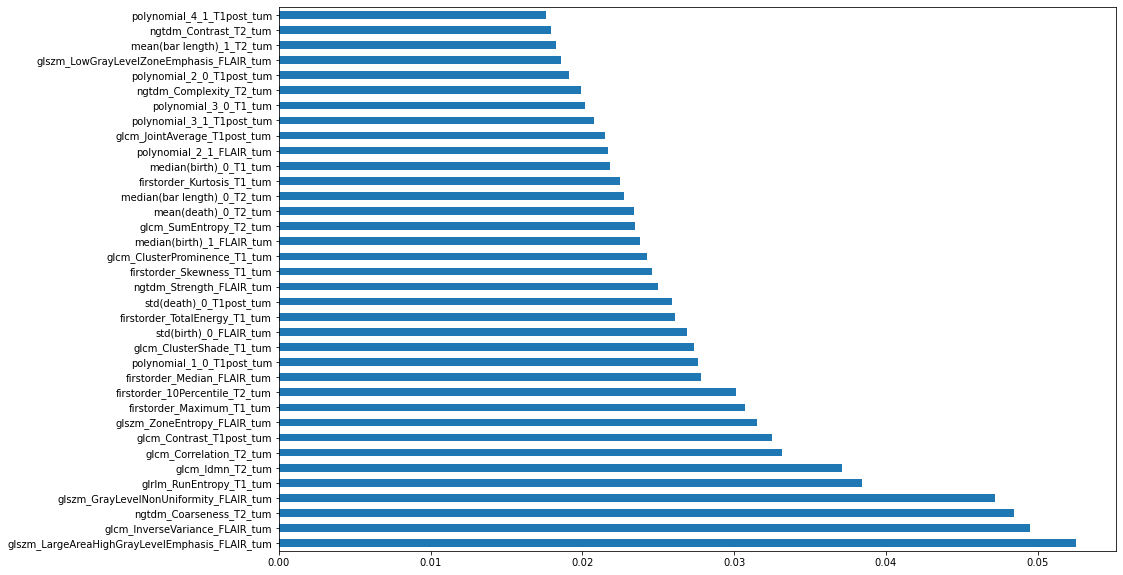

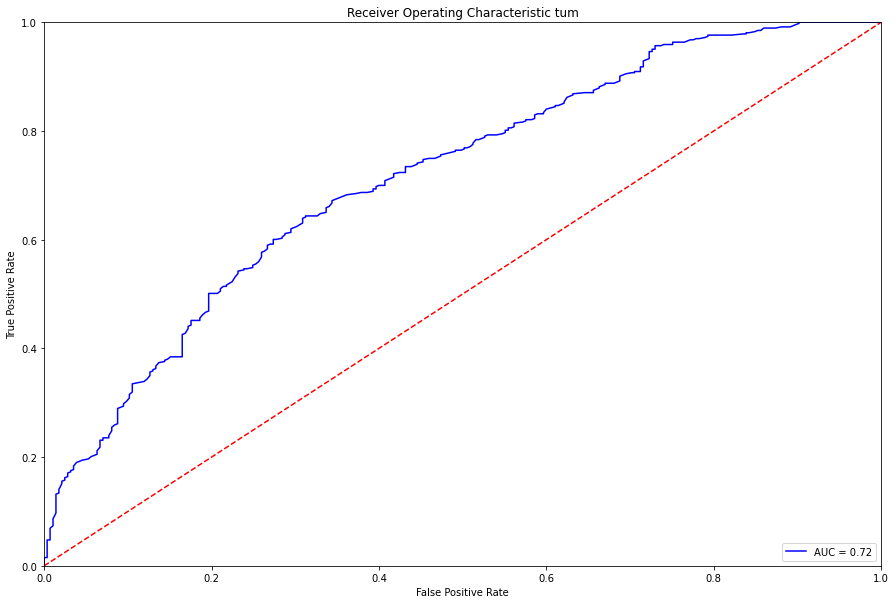

C:\Users\ncwang\AppData\Local\Continuum\anaconda3\envs\tcia\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


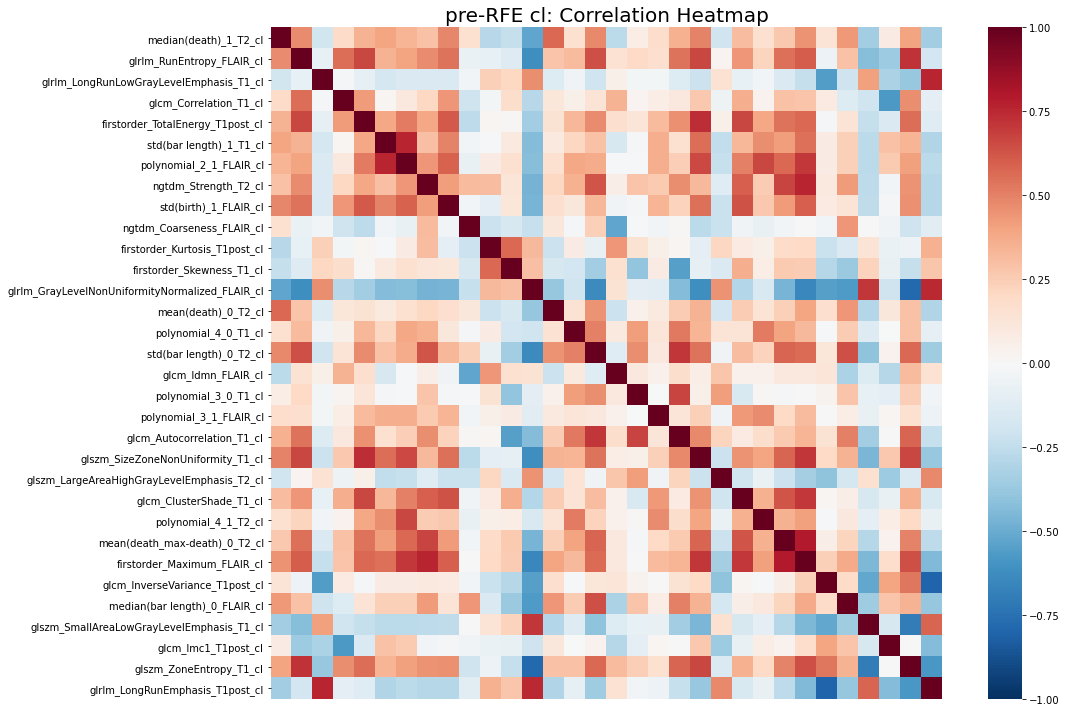

No handles with labels found to put in legend.


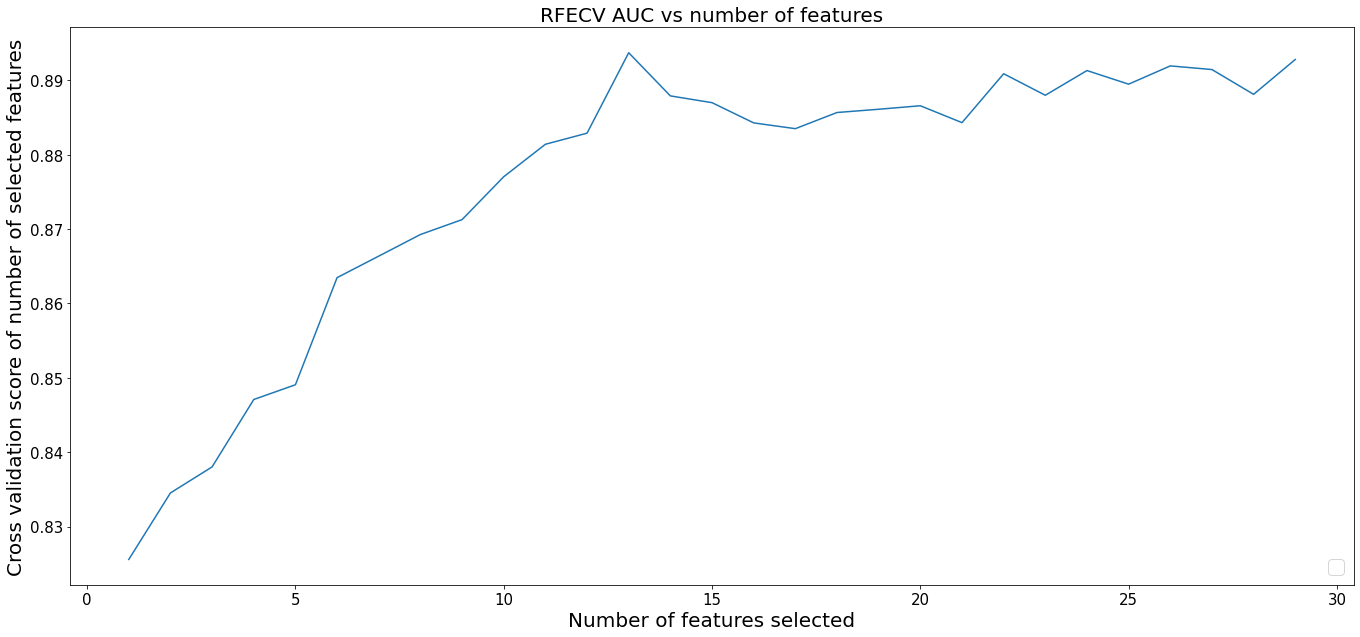

16 32 0.5


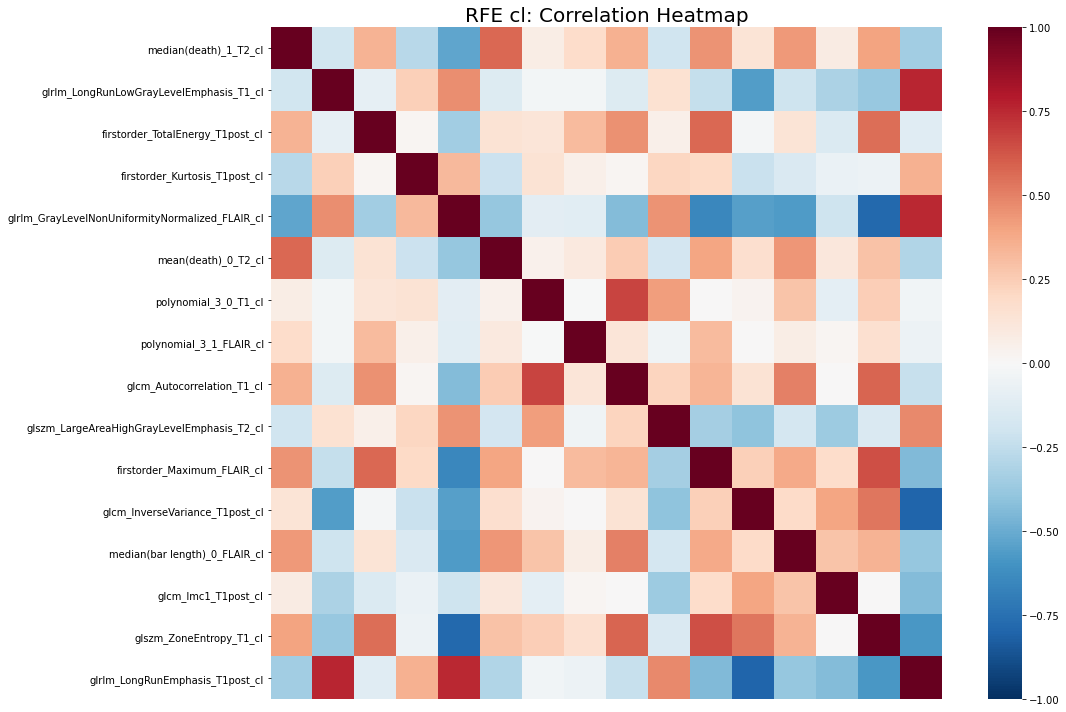

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


rf_auc: 0.9923452768729643


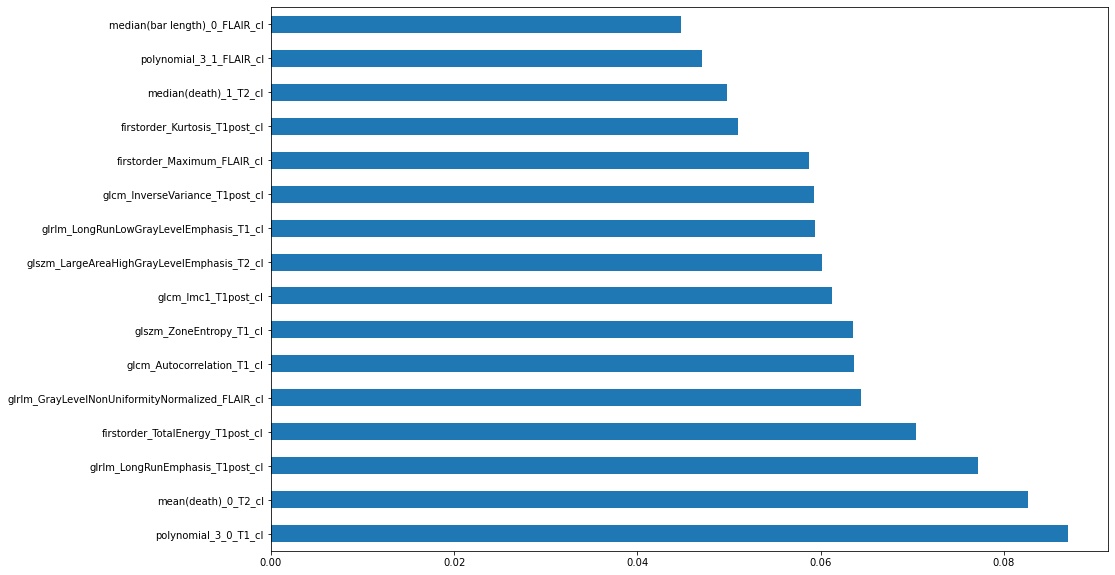

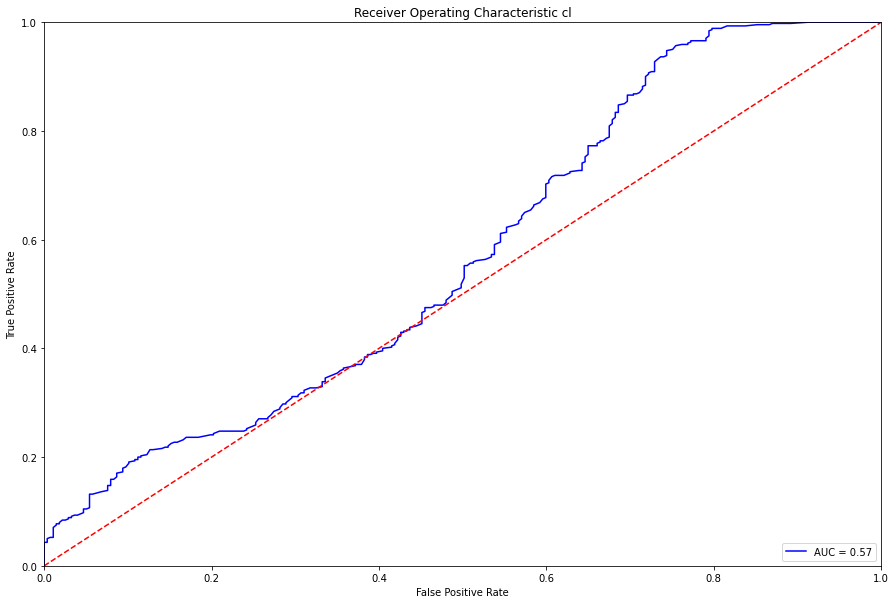

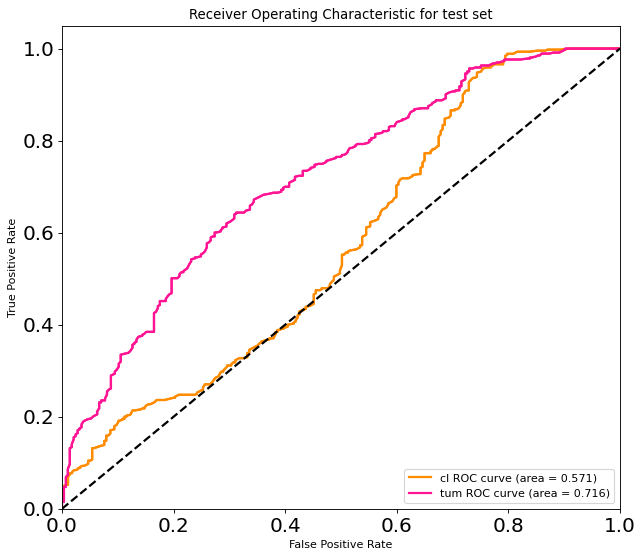

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso)
from boruta import BorutaPy


model_type = 'tum'    
colGen = 'shape_VoxelVolume_T1'
id_col = 'patient'
id_cols = ['sliceNo','patient']
y_col = 'IDH_TF'
y_Name = "IDH"

result = {}

for model_type in ['tum','cl']:
    feat_set = featDict[model_type]
    feat_cols = list(feat_set.values())

    szCol = feat_set[colGen]
    sizeMedian = combDF[[szCol,id_col]].groupby(id_col).quantile(.5)
    sizeMask = np.zeros((combDF.shape[0],1),dtype = bool)
    for rI in range(len(sizeMask)):
        pId = combDF.iloc[rI][id_col]
        pMed = sizeMedian.loc[pId]
        sizeMask[rI] = combDF.iloc[rI][szCol] >=pMed
    sizeMask = sizeMask.flatten()
    data_train = combDF.loc[np.logical_and(tMask,sizeMask)].copy()

    # # median value of the dataset
    # data_train['1p19q'] = data_train['1p19q'].astype(float)
    # data_train = data_train[feat_cols+[id_col,y_col]].groupby(id_col).quantile(.5)
    # data_train['patient'] = data_train.index
    # id_cols = ["patient"] 

    data_train = data_train.dropna(axis = 0,subset=feat_cols)

    curr_cols = feat_cols + id_cols +  [y_col]
    data_train = data_train.filter(curr_cols)

    features_selected = []
    tr_res = {}


    data_train = data_train.dropna(axis = 0,subset=feat_cols)
    curr_cols = feat_cols + id_cols + [y_col]
    # curr_cols = feat_cols + [id_col, y_col]
    data_train = data_train.filter(curr_cols)

    train_id,pids =  pd.factorize(data_train['patient'])
    train_Y = data_train[y_col].eq(1) 
    data_train_to_rfe = data_train.drop(id_cols + [y_col], axis=1).copy()

    # drop out CNN Features
    CNNFeats =  [col for col in data_train_to_rfe.columns.tolist() if "CNN_" in col]
    data_train_to_rfe = data_train_to_rfe.drop(CNNFeats, axis=1)
    
    # drop out shape features
    shapeFeats =  [col for col in data_train_to_rfe.columns.tolist() if "shape_" in col]
    data_train_to_rfe = data_train_to_rfe.drop(shapeFeats, axis=1)

    # correlation filter
    drop_features = find_correlation(data_train_to_rfe,thresh = 0.8)

    data_train_filtered = data_train_to_rfe.drop(drop_features,axis = 1)

    scaler = preprocessing.StandardScaler().fit(data_train_filtered)
    data_train_filtered.data = scaler.transform(data_train_filtered)

    corr_features = drop_features
    if data_train_filtered.shape[1] <= 1:
        features_rfe_selected = data_train_filtered.columns.tolist()
        rfecv_dict = features_rfe_selected

    # rfeMod = LinearSVC(C=.01)
    # rfeMod = Lasso(alpha = .05)
    # rfeMod = RandomForestClassifier()
    rfeMod = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5,random_state=random_seed)

    # define Boruta feature selection method

    gkf = StratifiedKFold(n_splits=5,random_state = random_seed,shuffle = True)#5-fold cross-validation - reduced because of grouping
    gkfSp = gkf.split(data_train_filtered,train_Y, groups = train_id)

    ftSel = "rfecv"
    if ftSel == 'rfecv':
        # The "roc_auc" scoring 
        rfecv = RFECV(
        estimator=rfeMod, 
        step=.01, 
        cv=gkfSp,
        scoring='roc_auc',
        n_jobs=-1,
        min_features_to_select= 4)   #5-fold cross-validation
        rfecv = rfecv.fit(data_train_filtered, train_Y)
        rfecv_dict = rfecv.grid_scores_


        drop_train_corr = data_train_filtered.corr()
        f, ax = plt.subplots(figsize=(15, 10))
        # Draw the heatmap using seaborn
        sns.heatmap(drop_train_corr, vmax=1,vmin =-1, square=True,cmap = 'RdBu_r', xticklabels = False)
        plt.title("pre-RFE %s: Correlation Heatmap"  % model_type, fontsize = 20)
        plt.tight_layout()
        # plt.savefig('Mean texture corr heatmap.png', bbox_inches = "tight")
        plt.show()

        plt.figure(figsize = (19,9))
        plt.xlabel("Number of features selected" , fontsize= 20)
        plt.ylabel("Cross validation score of number of selected features", fontsize = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)

        min_sz = len(rfecv_dict)

        plt.plot( range(1, min_sz +1), rfecv_dict[:min_sz]) 
        plt.legend(loc="lower right", fontsize = 20)
        plt.title("RFECV AUC vs number of features", fontsize = 20)
        plt.tight_layout()
        #             plt.savefig('RFECV_all_splits.png', bbox_inches = "tight")
        plt.show()
        features_rfecv_selected = data_train_filtered.columns[rfecv.support_].tolist()
        nC = len(data_train_filtered.columns)
        nSel = len(features_rfecv_selected)
        print(nSel,nC,nSel/nC)

        #         corr_rfe_dict = features_rfe_selected

        features_selected = features_rfecv_selected
    else:
        feat_selector = BorutaPy(rfeMod, n_estimators='auto', verbose=2, random_state=1)
        feat_selector.fit(data_train_filtered.data, train_Y)
        features_selected = data_train_filtered.columns[feat_selector.support_].tolist()

    # data_train_selected = data_train.filter(features_selected+ [y_col])
    sel_feat_corr = data_train.filter(features_selected+[y_col]).corr()

    f, ax = plt.subplots(figsize=(15, 10))
    # Draw the heatmap using seaborn
    sns.heatmap(sel_feat_corr, vmax=1,vmin =-1, square=True,cmap = 'RdBu_r', xticklabels = False)
    plt.title("RFE %s: Correlation Heatmap" % model_type, fontsize = 20)
    plt.tight_layout()
    # plt.savefig('Mean texture corr heatmap.png', bbox_inches = "tight")
    plt.show()

    np.save(os.path.join(out_dir,'%s_%s_%s_features.npy' % (ftSel,model_type,y_Name)), features_selected)

    from sklearn.metrics import roc_auc_score, roc_curve

    data_out = combDF.loc[sizeMask].copy()
    data_out = data_out.filter(items=(features_selected+['patient',y_col]))

    # # median value of the dataset
    # data_out['1p19q'] = data_out['1p19q'].astype(float)
    # data_out = data_out.groupby(id_col).quantile(.5)
    # data_out['patient'] = data_out.index

    data_out = data_out.dropna(axis = 0,how = 'all',subset=features_selected) # filter nans
    data_out = data_out.fillna(0)

    y_true = data_out[y_col].values.reshape([-1,1])

    roc_list = []
    for key in features_selected:
        x_vals = data_out[key].values.reshape([-1,1])
        roc_list = np.append(roc_list,roc_auc_score(y_true,x_vals))
    # print(roc_list)
    roc_df = pd.DataFrame(index=features_selected, data=roc_list, columns = ['roc'])

    #     f, ax = plt.subplots(figsize=(15, 10))
    #     # Draw the heatmap using seaborn
    #     sns.heatmap(data_out_corr, vmax=1,vmin =-1, square=True,cmap = 'RdBu_r', xticklabels = False)
    #     plt.title("%s: Correlation Heatmap" % (analysis_str), fontsize = 20)
    #     plt.tight_layout()
    #     plt.savefig('%s corr heatmap.png' % (analysis_str), bbox_inches = "tight")
    #     plt.show()
    #     #print(data_out.loc[data_out['patient']==5])
    #     #print(mean_data_out)
    d_out = data_out.drop(['patient'], axis=1)
    # data_corr = d_out.corr()

    # f, ax = plt.subplots(figsize=(15, 10))
    # Draw the heatmap using seaborn
    # sns.clustermap(data_corr, vmax=1,vmin =-1, square=True,cmap = 'RdBu_r', xticklabels = False)
    # plt.title("%s: Correlation Heatmap" % model_type, fontsize = 20)
    # plt.tight_layout()
    # plt.savefig('%s corr heatmap.png' % model_type, bbox_inches = "tight")
    # plt.show()


    # Method 1: Random forest classifier  
    # rfc = RandomForestClassifier(class_weight = "balanced") 
    rfc = RandomForestClassifier(random_state=random_seed)
    trMask = (data_out['patient'].isin(u_label_id_comb[tt0,0]))

    # train_id =  pd.to_numeric(data_train['patient'], errors='coerce')
    data_train = data_out.loc[trMask].copy()

    train_id,pids =  pd.factorize(data_train['patient'])
    train_Y = data_train[y_col]*1

    data_filtered = data_train.filter(items=(features_selected))

    # define the grid to search
    grid1 = random_grid()

    # k-fold split
    kf = StratifiedKFold(n_splits=5,random_state = random_seed,shuffle = True) #5-fold cross-validation
    kfSp = kf.split(data_filtered,train_Y, groups = train_id)
    # 5 fold cross validation with random grid search
    rf_res = RandomizedSearchCV(estimator = rfc,
                                           param_distributions = grid1, scoring = 'roc_auc',
                                           n_iter = 100, cv = kfSp, verbose=2, random_state=random_seed, n_jobs = -1)
    rf_res.fit(data_filtered,train_Y)

    best_rf = rf_res.best_estimator_
    pred_probs = best_rf.predict_proba(data_filtered)[:,1].reshape(-1,1)
    y_true = train_Y.values.reshape([-1,1])
    organize_result(tr_res, model_type, y_true, pred_probs)

    #save this model
    best_rf_dict = best_rf.__dict__
    np.save(os.path.join(model_dir,'rf_%s_%s.npy' % (model_type,y_Name)), best_rf_dict)

    #print(best_rf_dict)
    print('rf_auc:',rf_res.best_score_)
    f, ax = plt.subplots(figsize=(15, 10))
    (pd.Series(best_rf.feature_importances_, index=data_filtered.columns)
       .nlargest(data_filtered.shape[1])
       .plot(kind='barh')) 

    tsMask = (data_out['patient'].isin(u_label_id_comb[tt1,0]))
    data_test = data_out.loc[tsMask].copy()

    test_Y = data_test[y_col]*1
    data_filtered = data_test.filter(items=(features_selected))
    pred_probs = best_rf.predict_proba(data_filtered)[:,1].reshape(-1,1)

    fpr, tpr, threshold = metrics.roc_curve(test_Y, pred_probs)
    roc_auc = metrics.auc(fpr, tpr)
    y_true = test_Y.values.reshape([-1,1])

    # method I: plt

    f, ax = plt.subplots(figsize=(15, 10))
    plt.title('Receiver Operating Characteristic %s' % model_type)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    organize_result(result, model_type, y_true, pred_probs)
    test_id,pids =  pd.factorize(data_test['patient'])
    # print({y_col:test_Y,id_col:test_id,'pred_prob':pred_probs})
    outDF = pd.DataFrame({id_col:test_id, 
                  y_col:test_Y, 
                  'pred_prob':pred_probs.flatten()})
    outDF.to_csv(os.path.join(splitdir,'%s_%s_probs.csv' % (y_Name,model_type)))

draw_ROC_curve(result)

In [59]:
print(len(data_train_to_rfe.columns), len(data_train_filtered.columns))
print(len(data_filtered.columns))

428 32
16


In [57]:
result

{'tum': {'Youden Accuracy': 0.6590909090909091,
  'Sensitivity': 0.6436285097192225,
  'Specificity': 0.687719298245614,
  'AUC': 0.716047137281649,
  'AUC Upper': 0.7533920940170941,
  'AUC Lower': 0.6754352678571429,
  'fpr': array([0.        , 0.        , 0.        , 0.00350877, 0.00350877,
         0.00701754, 0.00701754, 0.00701754, 0.00701754, 0.00701754,
         0.01052632, 0.01052632, 0.01403509, 0.01403509, 0.01403509,
         0.01403509, 0.01403509, 0.01403509, 0.01403509, 0.01403509,
         0.01754386, 0.01754386, 0.02105263, 0.02105263, 0.0245614 ,
         0.0245614 , 0.02807018, 0.02807018, 0.03157895, 0.03157895,
         0.03508772, 0.03508772, 0.03859649, 0.04561404, 0.05263158,
         0.05614035, 0.06315789, 0.06315789, 0.06315789, 0.06666667,
         0.06666667, 0.07017544, 0.07017544, 0.07719298, 0.07719298,
         0.08070175, 0.08070175, 0.08421053, 0.0877193 , 0.0877193 ,
         0.0877193 , 0.0877193 , 0.0877193 , 0.09473684, 0.09473684,
         0.0982

In [51]:
combDF.loc[sizeMask].loc[tsMask].copy()[pred_probs < .2]

,sliceNo,firstorder_10Percentile_FLAIR_tum,firstorder_90Percentile_FLAIR_tum,firstorder_Energy_FLAIR_tum,firstorder_Entropy_FLAIR_tum,firstorder_InterquartileRange_FLAIR_tum,firstorder_Kurtosis_FLAIR_tum,firstorder_Maximum_FLAIR_tum,firstorder_Mean_FLAIR_tum,firstorder_MeanAbsoluteDeviation_FLAIR_tum,...,sliceNo.1,patient,age,gender,IDH,1p19q,IDH_1p19q,overall_survival,KPS,IDH_TF
331,24,-0.909917,0.421031,927.435410,3.134038,0.677242,4.078793,2.204425,-0.279369,0.425322,...,24,TCGA-02-0047,22,male,Mutant,0,IDHmut-non-codel,8.47656,90,1
410,14,-0.729125,0.834508,783.188054,3.411544,0.822152,4.598788,3.105749,0.053509,0.507971,...,14,TCGA-02-0054,57,female,Mutant,1,IDHmut-codel,8.0166,90,1
411,15,-0.732482,0.860524,905.029607,3.457194,0.898369,5.410106,3.848191,0.075084,0.537461,...,15,TCGA-02-0054,57,female,Mutant,1,IDHmut-codel,8.0166,90,1
414,18,-0.831558,0.929515,1135.182792,3.572043,0.905094,4.954550,3.701452,0.047581,0.571873,...,18,TCGA-02-0054,57,female,Mutant,1,IDHmut-codel,8.0166,90,1
420,24,-0.833371,1.231043,1544.085176,3.736064,1.059376,3.562064,3.400572,0.153877,0.643927,...,24,TCGA-02-0054,57,female,Mutant,1,IDHmut-codel,8.0166,90,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,56,-0.888247,1.077144,2028.089954,3.594592,0.985010,2.825168,2.767318,0.104414,0.593215,...,56,TCGA-DU-7008,71,male,WT,0,IDHwt,28.4523,100,0
5111,57,-0.882774,1.149911,2116.385501,3.623610,1.005278,2.654387,2.972376,0.136394,0.608611,...,57,TCGA-DU-7008,71,male,WT,0,IDHwt,28.4523,100,0
5112,58,-0.881316,1.240764,2208.128713,3.655956,1.048942,2.545249,2.413172,0.175108,0.627281,...,58,TCGA-DU-7008,71,male,WT,0,IDHwt,28.4523,100,0
5113,59,-0.888972,1.311887,2390.939703,3.720473,1.125001,2.478095,2.429036,0.216823,0.661534,...,59,TCGA-DU-7008,71,male,WT,0,IDHwt,28.4523,100,0


In [50]:
pred_probs[pred_probs >.8]

IndexError: too many indices for array

In [26]:
test_id,pids =  pd.factorize(data_test['patient'])
# print({y_col:test_Y,id_col:test_id,'pred_prob':pred_probs})
pd.DataFrame({id_col:test_id, 
              y_col:test_Y, 
              'pred_prob':pred_probs.flatten()})
# print(test_Y,test_id,pred_probs)

,patient,IDH_TF,pred_prob
57,0,1,0.470999
58,0,1,0.470658
59,0,1,0.435051
60,0,1,0.464099
61,0,1,0.451259
...,...,...,...
6818,21,0,0.443001
6819,21,0,0.454690
6820,21,0,0.450533
6821,21,0,0.455978


In [36]:
# print(data_train_to_rfe.columns.tolist())
[col for col in data_train_to_rfe.columns.tolist() if "CNN_" in col]

['CNN_457_T2_cl',
 'CNN_088_FLAIR_cl',
 'CNN_343_T2_cl',
 'CNN_488_T2_cl',
 'CNN_024_T1post_cl',
 'CNN_050_T1_cl',
 'CNN_341_T1post_cl',
 'CNN_240_T2_cl',
 'CNN_205_T2_cl',
 'CNN_087_T1_cl',
 'CNN_504_T1post_cl',
 'CNN_187_T1_cl',
 'CNN_117_T1post_cl',
 'CNN_202_T2_cl',
 'CNN_236_T1post_cl',
 'CNN_398_T2_cl',
 'CNN_452_T1post_cl',
 'CNN_158_T1_cl',
 'CNN_259_T1post_cl',
 'CNN_494_T2_cl',
 'CNN_469_T2_cl',
 'CNN_233_T1post_cl',
 'CNN_479_T2_cl',
 'CNN_339_FLAIR_cl',
 'CNN_372_T2_cl',
 'CNN_132_FLAIR_cl',
 'CNN_273_FLAIR_cl',
 'CNN_367_FLAIR_cl',
 'CNN_303_T2_cl',
 'CNN_405_T1post_cl',
 'CNN_507_T1_cl',
 'CNN_451_T1post_cl',
 'CNN_399_T1_cl',
 'CNN_508_FLAIR_cl',
 'CNN_379_T1post_cl',
 'CNN_027_T1_cl',
 'CNN_402_T2_cl',
 'CNN_296_T2_cl',
 'CNN_502_T1post_cl',
 'CNN_421_T1_cl',
 'CNN_007_T1_cl',
 'CNN_497_T1_cl',
 'CNN_290_T1_cl',
 'CNN_292_FLAIR_cl',
 'CNN_078_FLAIR_cl',
 'CNN_461_T1_cl',
 'CNN_287_T1post_cl',
 'CNN_286_T1post_cl',
 'CNN_036_T1post_cl',
 'CNN_032_FLAIR_cl',
 'CNN_410_FLA

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.5min finished


rf_auc: 0.6430019058917817


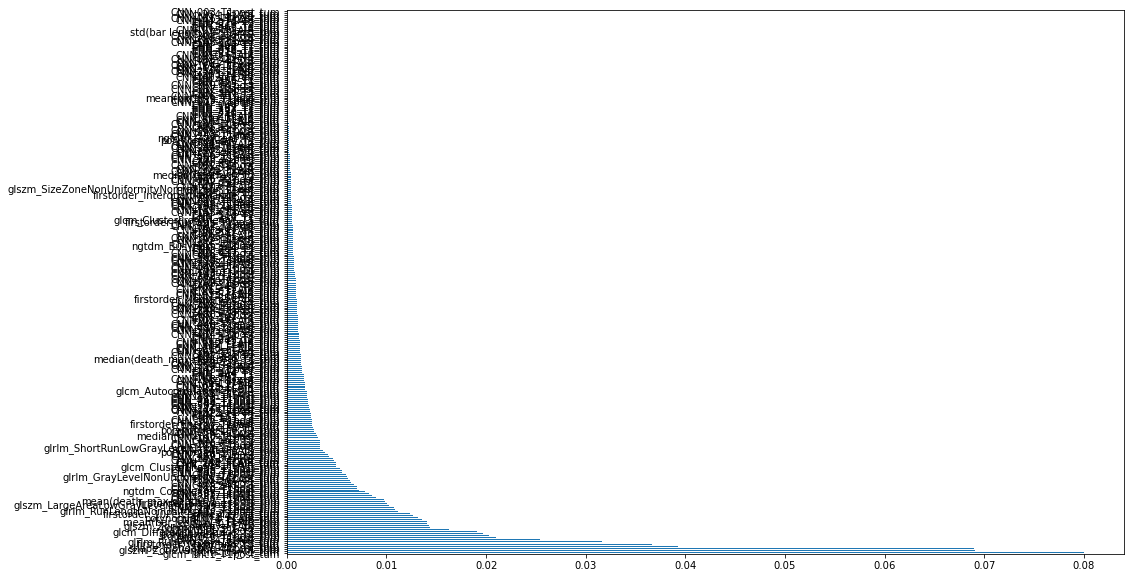

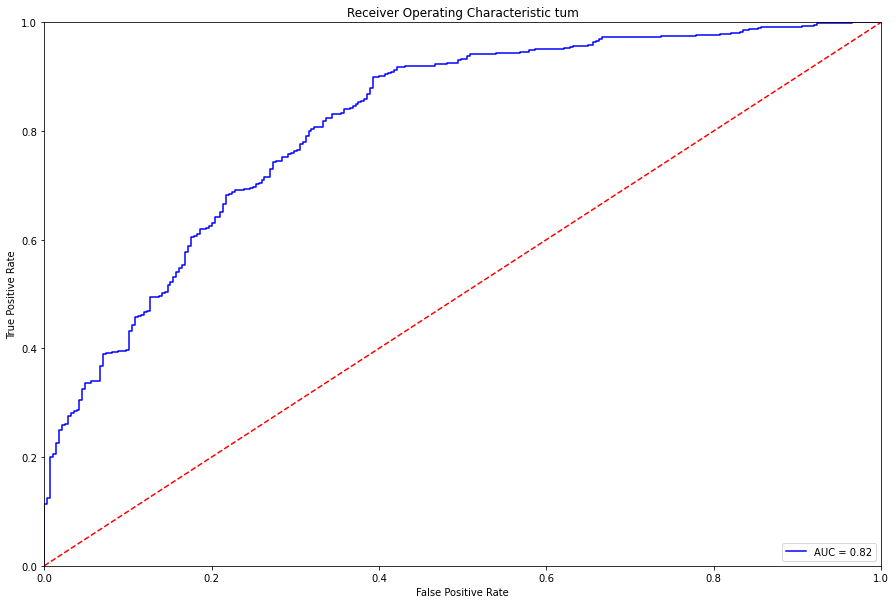

{'tum': {'Youden Accuracy': 0.786096256684492,
  'Sensitivity': 0.8984881209503239,
  'Specificity': 0.6070175438596491,
  'AUC': 0.8150960554734569,
  'AUC Upper': 0.8445039808676172,
  'AUC Lower': 0.779564295353769,
  'fpr': array([0.        , 0.        , 0.        , 0.00350877, 0.00350877,
         0.00701754, 0.00701754, 0.01052632, 0.01052632, 0.01403509,
         0.01403509, 0.01754386, 0.01754386, 0.02105263, 0.02105263,
         0.0245614 , 0.0245614 , 0.02807018, 0.02807018, 0.03157895,
         0.03157895, 0.03508772, 0.03508772, 0.03859649, 0.03859649,
         0.04210526, 0.04210526, 0.04561404, 0.04561404, 0.04912281,
         0.04912281, 0.05614035, 0.05614035, 0.06666667, 0.06666667,
         0.07017544, 0.07017544, 0.07368421, 0.07368421, 0.08070175,
         0.08070175, 0.0877193 , 0.0877193 , 0.09824561, 0.09824561,
         0.10175439, 0.10175439, 0.10526316, 0.10526316, 0.10877193,
         0.10877193, 0.1122807 , 0.1122807 , 0.11578947, 0.11578947,
         0.1192

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

data_out = combDF.loc[sizeMask].copy()
data_out = data_out.filter(items=(features_selected+['patient',y_col]))

# # median value of the dataset
# data_out['1p19q'] = data_out['1p19q'].astype(float)
# data_out = data_out.groupby(id_col).quantile(.5)
# data_out['patient'] = data_out.index

data_out = data_out.dropna(axis = 0,how = 'all',subset=features_selected) # filter nans
data_out = data_out.fillna(0)

y_true = data_out[y_col].values.reshape([-1,1])

roc_list = []
for key in features_selected:
    x_vals = data_out[key].values.reshape([-1,1])
    roc_list = np.append(roc_list,roc_auc_score(y_true,x_vals))
# print(roc_list)
roc_df = pd.DataFrame(index=features_selected, data=roc_list, columns = ['roc'])

#     f, ax = plt.subplots(figsize=(15, 10))
#     # Draw the heatmap using seaborn
#     sns.heatmap(data_out_corr, vmax=1,vmin =-1, square=True,cmap = 'RdBu_r', xticklabels = False)
#     plt.title("%s: Correlation Heatmap" % (analysis_str), fontsize = 20)
#     plt.tight_layout()
#     plt.savefig('%s corr heatmap.png' % (analysis_str), bbox_inches = "tight")
#     plt.show()
#     #print(data_out.loc[data_out['patient']==5])
#     #print(mean_data_out)
d_out = data_out.drop(['patient'], axis=1)
# data_corr = d_out.corr()

# f, ax = plt.subplots(figsize=(15, 10))
# Draw the heatmap using seaborn
# sns.clustermap(data_corr, vmax=1,vmin =-1, square=True,cmap = 'RdBu_r', xticklabels = False)
# plt.title("%s: Correlation Heatmap" % model_type, fontsize = 20)
# plt.tight_layout()
# plt.savefig('%s corr heatmap.png' % model_type, bbox_inches = "tight")
# plt.show()


# Method 1: Random forest classifier  
# rfc = RandomForestClassifier(class_weight = "balanced") 
rfc = RandomForestClassifier()
trMask = (data_out['patient'].isin(u_label_id_comb[tt0,0]))

# train_id =  pd.to_numeric(data_train['patient'], errors='coerce')
data_train = data_out.loc[trMask].copy()

train_id,pids =  pd.factorize(data_train['patient'])
train_Y = data_train[y_col]*1

data_filtered = data_train.filter(items=(features_selected))

# define the grid to search
grid1 = random_grid()

# k-fold split
kf = StratifiedKFold(n_splits=5) #5-fold cross-validation
kfSp = kf.split(data_filtered,train_Y, groups = train_id)
# 5 fold cross validation with random grid search
rf_res = RandomizedSearchCV(estimator = rfc,
                                       param_distributions = grid1, scoring = 'roc_auc',
                                       n_iter = 100, cv = kfSp, verbose=2, random_state=42, n_jobs = -1)
rf_res.fit(data_filtered,train_Y)

best_rf = rf_res.best_estimator_
pred_probs = best_rf.predict_proba(data_filtered)[:,1].reshape(-1,1)
y_true = train_Y.values.reshape([-1,1])
organize_result(tr_res, model_type, y_true, pred_probs)

#save this model
best_rf_dict = best_rf.__dict__
np.save(os.path.join(model_dir,'rf_%s_%s.npy' % (model_type,y_Name)), best_rf_dict)

#print(best_rf_dict)
print('rf_auc:',rf_res.best_score_)
f, ax = plt.subplots(figsize=(15, 10))
(pd.Series(best_rf.feature_importances_, index=data_filtered.columns)
   .nlargest(data_filtered.shape[1])
   .plot(kind='barh')) 

tsMask = (data_out['patient'].isin(u_label_id_comb[tt1,0]))
data_test = data_out.loc[tsMask].copy()

test_Y = data_test[y_col]*1
data_filtered = data_test.filter(items=(features_selected))
pred_probs = best_rf.predict_proba(data_filtered)[:,1].reshape(-1,1)

fpr, tpr, threshold = metrics.roc_curve(test_Y, pred_probs)
roc_auc = metrics.auc(fpr, tpr)
y_true = test_Y.values.reshape([-1,1])

# method I: plt

f, ax = plt.subplots(figsize=(15, 10))
plt.title('Receiver Operating Characteristic %s' % model_type)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

organize_result(result, model_type, y_true, pred_probs)


In [36]:
tumDF = combDF.copy().filter(curr_cols)
# tumDF
tumDF.to_csv(os.path.join(splitdir,'tumPatData.csv'))


In [29]:
print(data_filtered.shape,train_Y.shape)

(1336, 283) (5599,)


In [33]:
print(best_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [127]:
test_id,pids =  pd.factorize(data_test['patient'])
probDF = pd.DataFrame(pred_probs,index=test_id,columns=["pred_prob"])
lblDF = pd.DataFrame(y_true,index=test_id,columns=["1p19q"])
combDF = pd.concat([probDF,lblDF],axis=1)

mean_results = combDF.groupby(combDF.index).aggregate(np.mean)
organize_result(result, model_type, mean_results["1p19q"].to_numpy(), mean_results["pred_prob"].to_numpy())
# lblDF.groupby(lblDF.index).aggregate(np.median)


{'tum': {'Youden Accuracy': 0.6818181818181818,
  'Sensitivity': 0.5,
  'Specificity': 0.75,
  'AUC': 0.475,
  'AUC Upper': 0.9,
  'AUC Lower': 0.09523809523809523,
  'fpr': array([0.  , 0.05, 0.25, 0.25, 0.8 , 0.8 , 1.  ]),
  'tpr': array([0. , 0. , 0. , 0.5, 0.5, 1. , 1. ]),
  'threshold': array([1.45915264, 0.45915264, 0.3506197 , 0.3001    , 0.19495342,
         0.1749467 , 0.06557803]),
  'Youden thresh': 0.300099997638667,
  'Youden PPV': 0.0,
  'Youden NPV': 0.6818181818181818}}

In [37]:
slTex = np.load(r"C:\Users\ncwang\Box\1p19q Project\data\data_split_n4\slices_texture_features.npy")
texFtNames = np.load(r"C:\Users\ncwang\Box\1p19q Project\data\data_split_n4\texture_feature_names.npy")
texDF = pd.DataFrame(slTex,columns=texFtNames)
print(slTex)
texDF

[[-3.74345749e-01  2.03719328e+00  1.41441525e+04 ...  1.79151894e+04
   2.12024531e+00  8.70400000e+03]
 [-2.36239757e-01  1.71529611e+00  1.12181828e+04 ...  2.31977012e+04
   2.09450600e+00  1.13310000e+04]
 [ 2.30607146e-01  1.35138944e+00  7.94458158e+03 ...  1.71820888e+04
   2.09114763e+00  8.40300000e+03]
 ...
 [-3.60154324e-01  1.27585540e+00  6.96227650e+03 ...  2.45061189e+04
   2.04926361e+00  1.21010000e+04]
 [-3.89554847e-01  1.32786809e+00  7.52410978e+03 ...  2.45376891e+04
   2.04666933e+00  1.21250000e+04]
 [-3.54927983e-01  1.29705593e+00  7.05915016e+03 ...  2.45679159e+04
   2.04839320e+00  1.21350000e+04]]


,firstorder_10Percentile_FLAIR,firstorder_90Percentile_FLAIR,firstorder_Energy_FLAIR,firstorder_Entropy_FLAIR,firstorder_InterquartileRange_FLAIR,firstorder_Kurtosis_FLAIR,firstorder_Maximum_FLAIR,firstorder_Mean_FLAIR,firstorder_MeanAbsoluteDeviation_FLAIR,firstorder_Median_FLAIR,...,shape_Maximum2DDiameterColumn_T2,shape_Maximum2DDiameterRow_T2,shape_Maximum2DDiameterSlice_T2,shape_Maximum3DDiameter_T2,shape_MeshVolume_T2,shape_MinorAxisLength_T2,shape_Sphericity_T2,shape_SurfaceArea_T2,shape_SurfaceVolumeRatio_T2,shape_VoxelVolume_T2
0,-0.374346,2.037193,14144.152452,3.861662,1.132109,6.014418,5.608251,0.735020,0.769984,0.530593,...,137.0,129.0,148.660687,148.660687,8449.583333,109.329766,0.111983,17915.189430,2.120245,8704.0
1,-0.236240,1.715296,11218.182843,3.568135,0.960669,4.465861,4.218462,0.594310,0.612796,0.433369,...,132.0,132.0,152.505738,152.505738,11075.500000,109.274939,0.103581,23197.701233,2.094506,11331.0
2,0.230607,1.351389,7944.581579,2.929615,0.650840,3.819508,2.153445,0.843506,0.382684,0.937770,...,141.0,138.0,153.935051,153.935051,8216.583333,118.031763,0.114605,17182.088781,2.091148,8403.0
3,0.200568,1.157442,6564.198454,2.723734,0.484068,4.808555,1.885169,0.694372,0.313759,0.740902,...,135.0,142.0,161.697248,161.697248,9900.416667,96.512676,0.109142,20429.619151,2.063511,10060.0
4,0.558672,4.670599,139714.057636,4.705950,2.159879,3.376762,8.342659,2.592278,1.298260,2.684870,...,142.0,142.0,162.052461,162.052461,14637.333333,118.357188,0.097243,29757.762646,2.033004,14758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,-0.378576,1.269248,7351.536635,3.440587,0.806420,3.983595,3.004858,0.363452,0.519396,0.295748,...,141.0,138.0,146.413797,146.413797,12165.916667,118.231749,0.102637,24923.679379,2.048648,12308.0
516,-0.370797,1.277541,7300.573783,3.428599,0.819234,3.776476,2.690728,0.365485,0.518347,0.294992,...,142.0,140.0,146.154028,146.154028,12253.750000,117.987784,0.102422,25096.022525,2.048028,12396.0
517,-0.360154,1.275855,6962.276503,3.392118,0.818244,3.578788,2.614314,0.376999,0.510511,0.302337,...,142.0,139.0,145.344419,145.344419,11958.500000,115.830225,0.103195,24506.118901,2.049264,12101.0
518,-0.389555,1.327868,7524.109777,3.449376,0.831887,3.504519,2.723151,0.388216,0.531521,0.308778,...,142.0,139.0,145.784087,145.784087,11989.083333,114.117253,0.103238,24537.689094,2.046669,12125.0


In [104]:
suffix = ''
corr_rfe_dict_orig = np.load(os.path.join(out_dir,'rfe_%s_features_selected%s.npy' % ('cmb',suffix)),allow_pickle=True).item()
print(corr_rfe_dict_orig[0])
features_selected = [ featDict[model_type][key] for key in corr_rfe_dict_orig[0]]
print(features_selected)


['CNN_039_T1post', 'CNN_044_T1post', 'CNN_046_T1post', 'CNN_048_T1post', 'CNN_049_T1post', 'CNN_056_T1post', 'CNN_058_T1post', 'CNN_075_T1post', 'CNN_078_T1post', 'CNN_088_T1post', 'CNN_095_T1post', 'CNN_100_T1post', 'CNN_101_T1post', 'CNN_122_T1post', 'CNN_129_T1post', 'CNN_130_T1post', 'CNN_138_T1post', 'CNN_140_T1post', 'CNN_155_T1post', 'CNN_164_T1post', 'CNN_170_T1post', 'CNN_171_T1post', 'CNN_173_T1post', 'CNN_200_T1post', 'CNN_256_T1post', 'CNN_260_T1post', 'CNN_272_T1post', 'CNN_280_T1post', 'CNN_287_T1post', 'CNN_328_T1post', 'CNN_366_T1post', 'CNN_384_T1post', 'CNN_385_T1post', 'CNN_437_T1post', 'CNN_443_T1post', 'CNN_446_T1post', 'CNN_458_T1post', 'CNN_461_T1post', 'CNN_468_T1post', 'CNN_472_T1post', 'CNN_475_T1post', 'CNN_479_T1post', 'CNN_483_T1post', 'CNN_484_T1post', 'CNN_490_T1post', 'CNN_506_T1post', 'CNN_507_T1post', 'CNN_509_T1post', 'CNN_011_T2', 'CNN_016_T2', 'CNN_019_T2', 'CNN_026_T2', 'CNN_051_T2', 'CNN_096_T2', 'CNN_126_T2', 'CNN_133_T2', 'CNN_142_T2', 'CNN_145_

In [108]:
print(features_selected)


['glszm_LargeAreaLowGrayLevelEmphasis_T2_tum', 'glszm_ZoneVariance_T2_tum', 'glrlm_LongRunHighGrayLevelEmphasis_T2_tum', 'shape_Maximum2DDiameterSlice_T2_tum', 'ngtdm_Complexity_T1post_tum', 'glcm_ClusterProminence_FLAIR_tum', 'glcm_ClusterShade_FLAIR_tum', 'polynomial_3_0_T1_tum', 'glszm_LargeAreaHighGrayLevelEmphasis_T1_tum', 'ngtdm_Coarseness_T2_tum', 'glrlm_RunLengthNonUniformity_T1_tum', 'glszm_SmallAreaHighGrayLevelEmphasis_FLAIR_tum', 'firstorder_Energy_FLAIR_tum']


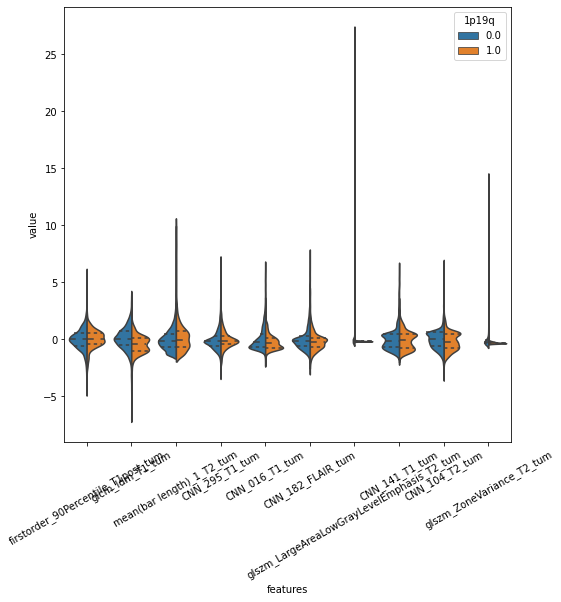

In [64]:
manual_features = data_train_filtered.columns[rfecv.ranking_==1].tolist()
manual_features = manual_features[0:10]
data_train_manual = data_train[manual_features]
data_train_manual_norm = (data_train_manual - data_train_manual.mean()) / (data_train_manual.std())

# data_train_manual_norm = (tempData - tempData.mean()) / (tempData.std())
# print(train_Y)

data_temp = pd.concat([train_Y, data_train_manual_norm], axis=1)

data_temp = pd.melt(data_temp,  id_vars = "1p19q",
								var_name = "features",
								value_name = "value")
data_temp
plt.figure(figsize=(8,8))
sns.violinplot(x="features", y="value", hue="1p19q", data=data_temp,split=True, inner="quart")

plt.xticks(rotation=30)
plt.show()